## TTT4275 Classification Project: Music Classification

In [4]:
# Imports
import source.data_handling
import source.mappings
import source.plotting
import source.diy_classifiers

import numpy as np


In [5]:
# Load the dataset and split into training and test
# X = M x N dataset with M samples of N features

data_version = source.data_handling.GENRE_CLASS_DATA_30S
data_set = source.data_handling.read_genre_class_data(data_version)

features = source.mappings.MUSIC_FEATURES_ALL

training_data, test_data = source.data_handling.prepare_data(
        data_frame=data_set,
        features=features,
    )
print(len(features))
print(training_data.y)
print(type(data_set))

63
0       pop
1       pop
2       pop
3       pop
4       pop
       ... 
787    jazz
788    jazz
789    jazz
790    jazz
791    jazz
Name: Genre, Length: 792, dtype: object
<class 'pandas.core.frame.DataFrame'>


In [6]:
print(source.data_handling.GENRE_CLASS_DATA_30S)
print(source.data_handling._file_path)

/home/nbresina/Documents/NTNU/EstimationDetectionClassification/Projects/ttt4275-music-classification/source/../resources/data/GenreClassData_30s.txt
/home/nbresina/Documents/NTNU/EstimationDetectionClassification/Projects/ttt4275-music-classification/source


## Task 1

Using only the four features given in task 1a), we plot the confusion matrix and error rate for all genres.

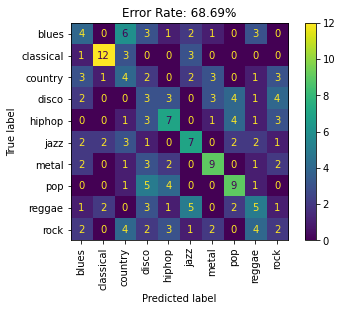

In [7]:
features_task_1 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_set,
    features=features_task_1,
)

y_pred_task1 = source.diy_classifiers.kNN(k=5, train_data=training_data, test_data=test_data, p=2)
y_true_task1 = test_data.y

source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

Using all features we plot the error rates with respect to the number of neighbors and using different orders of the Minkowski order (p).
Once for our own implementation of the kNN classifier

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 1  2  3  4  5  6  7  8  9 10]


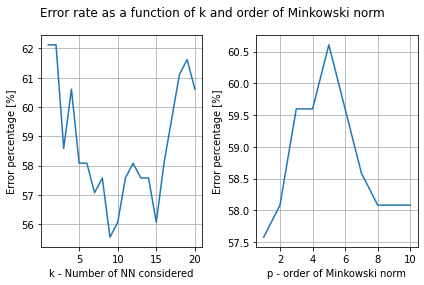

In [8]:
# kNN parameters
k = 5

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_set,
)

ks = np.arange(20) + 1
ps = np.arange(10) + 1

print(ks)
print(ps)

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=True)

And another time for the sklearn implementation

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 1  2  3  4  5  6  7  8  9 10]


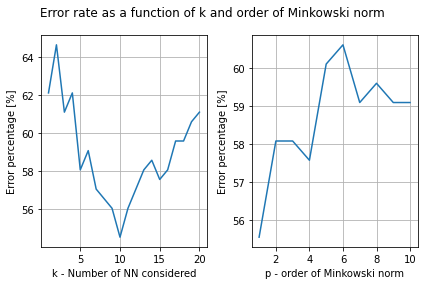

In [9]:
# kNN parameters
k = 5

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_set,
)

ks = np.arange(20) + 1
ps = np.arange(10) + 1

print(ks)
print(ps)

source.plotting.error_rates_vs_params(ks, ps, training_data, test_data, diy=False)

## Task 2

In [10]:
features_task_2 = ["spectral_rolloff_mean", "tempo", "spectral_centroid_mean", "mfcc_1_mean"]
genres_task_2 = ["pop", "disco", "metal", "classical"]

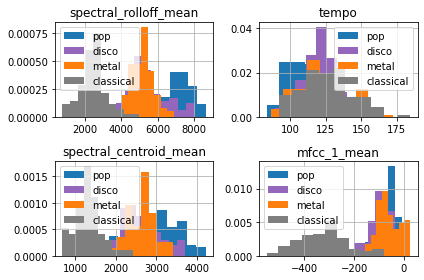

In [11]:
source.plotting.feature_distribution_histogram(
    data_frame=data_set,
    features=features_task_2,
    genres=genres_task_2,
)

As the tempo feature seems to have the largest overlap between the classes, we remove that feature and run the knn classifier from task 1 for all genres again.

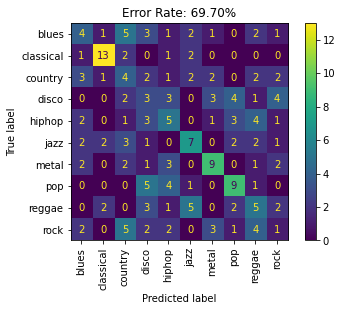

In [12]:
reduced_features_task_2 = ["spectral_rolloff_mean", "spectral_centroid_mean", "mfcc_1_mean"]

training_data, test_data = source.data_handling.prepare_data(
    data_frame=data_set,
    features=reduced_features_task_2,
)

y_pred_task1 = source.diy_classifiers.kNN(train_data=training_data, test_data=test_data, k=5, p=2)
y_true_task1 = test_data.y

source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

For whatever reason removing the tempo does not seem to have a valueable impact on the error rate of the classifier.

Using only one of the features we run the classifier and for the four genres and take a look at the performance.

spectral_rolloff_mean


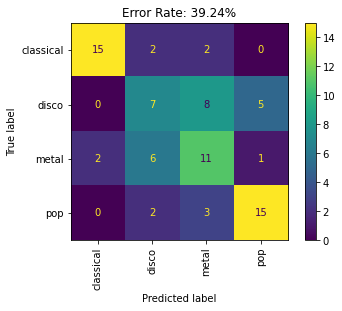

tempo


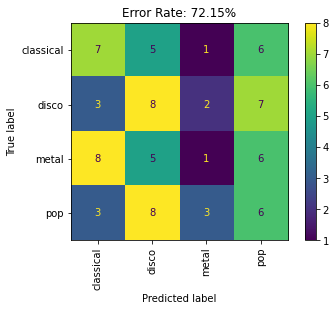

spectral_centroid_mean


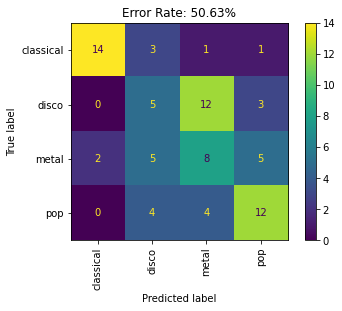

mfcc_1_mean


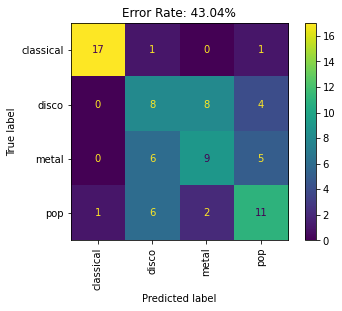

In [13]:
for feature in features_task_2:
    print(feature)
    training_data, test_data = source.data_handling.prepare_data(
        data_frame=data_set,
        features=[feature],
        genres=genres_task_2,
    )

    y_pred_task1 = source.diy_classifiers.kNN(train_data=training_data, test_data=test_data, k=5, p=2)
    y_true_task1 = test_data.y

    source.plotting.confusion_matrix(y_true_task1, y_pred_task1)

## Task 3 Plots

In [14]:
# Crazy code

## Task 4 plots

In [15]:
# Crazy code